Название: classify_lenta_ru_texts_playbook.ipynb

Автор: hwpy  
Дата: 2022 Май  
Описание: Обработка заголовков текстов, составление словаря, обучение классификатора  
Примечания:  
* Для демонстрации взят открытый датасет русскоязычных новостей Lenta.ru  
* https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/  

# Модель

**Загружаем стопслова**

In [42]:
import os
import ssl
import nltk

CUR_DIR = os.getcwd()
# Указать свою директорию
PATH_TO_NLTK_DATA = os.path.join(CUR_DIR, 'venv/nltk_data')
if not os.path.exists(PATH_TO_NLTK_DATA):
    os.makedirs(PATH_TO_NLTK_DATA)
if not os.listdir(PATH_TO_NLTK_DATA):
    try:
        _create_unverified_https_context = ssl._create_unverified_context  # pylint:disable=protected-access
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context  # pylint:disable=protected-access

    nltk.download('stopwords', download_dir=PATH_TO_NLTK_DATA)

**Импортируем модули и библиотеки**

In [43]:
from typing import List, Any
from IPython.display import display
import random
import re

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras import models, metrics  # type: ignore pylint: disable=import-error
# utils
from tensorflow.keras.models import Sequential  # type: ignore pylint: disable=no-name-in-module, import-error
from tensorflow.keras.optimizers import Adam  # type: ignore pylint: disable=no-name-in-module, import-error
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout  # type: ignore pylint: disable=no-name-in-module, import-error
# MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, GRU, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore pylint: disable=no-name-in-module, import-error
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore pylint: disable=no-name-in-module, import-error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # type: ignore pylint: disable=no-name-in-module, import-error
from tensorflow.keras.backend import clear_session  # type: ignore pylint: disable=no-name-in-module, import-error, unused-import

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  # confusion_matrix

nltk_stopwords = set(stopwords.words('russian'))
print(nltk_stopwords)

SEED = 42
random.seed(SEED)

{'к', 'без', 'после', 'три', 'больше', 'нельзя', 'наконец', 'этот', 'было', 'для', 'с', 'один', 'этого', 'ничего', 'вам', 'во', 'я', 'может', 'про', 'от', 'нас', 'том', 'этой', 'ведь', 'них', 'того', 'зачем', 'даже', 'до', 'или', 'над', 'то', 'ни', 'он', 'быть', 'еще', 'эти', 'вот', 'ему', 'всю', 'всегда', 'из', 'раз', 'тогда', 'но', 'она', 'на', 'всего', 'тем', 'когда', 'его', 'чтобы', 'если', 'были', 'впрочем', 'ней', 'иногда', 'их', 'потому', 'в', 'чтоб', 'нет', 'ним', 'им', 'можно', 'под', 'мы', 'какая', 'уж', 'какой', 'кто', 'что', 'да', 'при', 'же', 'только', 'тоже', 'бы', 'чего', 'была', 'как', 'моя', 'надо', 'другой', 'нее', 'почти', 'ли', 'никогда', 'свою', 'перед', 'уже', 'где', 'мой', 'есть', 'теперь', 'ее', 'опять', 'совсем', 'об', 'все', 'будет', 'хоть', 'него', 'тут', 'у', 'нибудь', 'конечно', 'тот', 'эту', 'тебя', 'а', 'всех', 'за', 'был', 'они', 'сейчас', 'разве', 'вдруг', 'там', 'такой', 'много', 'ты', 'два', 'здесь', 'вы', 'ну', 'меня', 'потом', 'ей', 'так', 'куда', '

**Загрузим датасет и посмотрим на него**

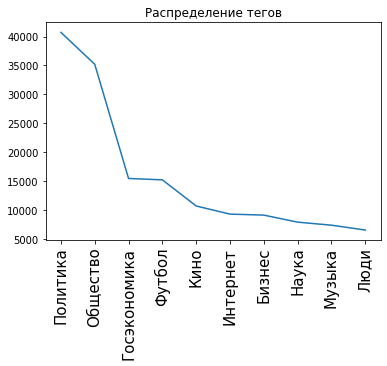

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157723 entries, 0 to 157722
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    157722 non-null  object
 1   tags    157723 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


,text,tags
0,Американского актера Уэсли Снайпса в четверг п...,Кино
1,Власти одного из районов столицы Южной Кореи з...,Общество
2,"""Федеральная пассажирская компания"", входящая ...",Бизнес
3,Вечером 26 ноября 2012 года из Москвы в Хельси...,Бизнес
4,"В Махачкале в четверг, 27 декабря, был задержа...",Политика
...,...,...
157718,YouTube назвал самые популярные музыкальные кл...,Музыка
157719,Ученые из Колледжа врачей и хирургов при Колум...,Наука
157720,"Белоруссия возьмет у Китая кредит на 3,5 милли...",Госэкономика
157721,Испытание США ранее запрещенной Договором о ли...,Политика


In [44]:
df_news = pd.read_csv('data/lenta-ru-news.csv', usecols=["text", "tags"])
# Включим только те теги, которые проставлены более 6000 раз
df_news = df_news[df_news['tags'].map(df_news['tags'].value_counts()) >= 6000]
df_news.reset_index(inplace=True, drop=True)
plt.plot(df_news["tags"].value_counts())
plt.xticks(rotation=90, fontsize=15)
plt.title("Распределение тегов")
plt.show()
# Отобразим df
df_news.info()
display(df_news)

**Добавим индексы классов**

In [45]:
classes = pd.DataFrame()
classes = df_news.tags.value_counts()
classes = classes.reset_index(inplace=False, drop=False)
classes = classes.rename(columns={'index': 'tag'})
classes = classes.reset_index(inplace=False, drop=False)
classes = classes.rename(columns={'index': 'tag_idx'})
classes.drop('tags', axis=1, inplace=True)
df_news = df_news.merge(classes, left_on='tags', right_on='tag')
df_news.head()

,text,tags,tag_idx,tag
0,Американского актера Уэсли Снайпса в четверг п...,Кино,4,Кино
1,"Режиссер Сэм Мендес, снявший ""007: Координаты ...",Кино,4,Кино
2,Кинокомпания Warner Bros. снимет фильм о жизни...,Кино,4,Кино
3,Австралийская певица Кайли Миноуг решила покин...,Кино,4,Кино
4,Телеканал NBC заказал съемки пилотного эпизода...,Кино,4,Кино


**Удалим спецсимволы и приведем к нижнему регистру**

In [46]:
def clean_text(text: str) -> str:
    """Очистить текст

    Аргументы:
        - text (str) - Текст документа

    Возвращает:
        str - очищенный регулярками replace_by_space_re, bad_symbols_re текст
    """

    replace_by_space_re = re.compile(r'[/(){}\[\]\|@,;:]')
    bad_symbols_re = re.compile(r'[#+_""'']')

    # Заменяем символы replace_by_space_re на пробел
    text = replace_by_space_re.sub(' ', str(text))
    # Удаление символов bad_symbols_re
    text = bad_symbols_re.sub(' ', str(text))
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем стоп слова
    text = ' '.join(word for word in text.split() if word not in nltk_stopwords)

    return text


df_news['text_cleaned'] = df_news['text'].apply(clean_text)
df_news.dropna()
df_news.tail()

,text,tags,tag_idx,tag,text_cleaned
157718,Определились все 16 участников плей-офф Лиги ч...,Футбол,3,Футбол,определились 16 участников плей-офф лиги чемпи...
157719,"Анна Семак, жена главного тренера петербургско...",Футбол,3,Футбол,анна семак жена главного тренера петербургског...
157720,Президент московского ЦСКА Евгений Гинер отстр...,Футбол,3,Футбол,президент московского цска евгений гинер отстр...
157721,"Элизабет Борель, проживающая в одном районе с ...",Футбол,3,Футбол,элизабет борель проживающая одном районе напад...
157722,Российские футбольные клубы впервые за 18 лет ...,Футбол,3,Футбол,российские футбольные клубы впервые 18 лет сыг...


**Объявим переменные**

In [ ]:
# Максимальное количество используемух слов (по частоте)
MAX_NB_WORDS = 100000
# Максимальное количество слов в документе
MAX_SEQUENCE_LENGTH = 200
# Размер эмбеддинга - длина вектора для каждого слова
EMBEDDING_DIM = 300
EPOCHS = 25
BATCH_SIZE = 64
MODEL_LSTM_SAVE_PATH = r'tf_models/best_lstm_classificator'
HISTORY_LSTM_SAVE_PATH = r'tf_models/history_lstm_classificator'
TOKENIZER_SAVE_PATH = r'tf_models/tokenizer.pickle'

**Токенайзер**

In [ ]:
tokenizer = Tokenizer(
    num_words=MAX_NB_WORDS,
    filters=r'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
    lower=True
)

tokenizer.fit_on_texts(df_news['text_cleaned'].values)
# сохраняем токенайзер
with open(TOKENIZER_SAVE_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
word_index = tokenizer.word_index
print('Найдено %s уникальных токенов.' % len(word_index))

**Токенизируем тексты**

In [ ]:
X = tokenizer.texts_to_sequences(df_news['text_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Размер тензора с векторами документов:', X.shape)

print(f"Предлжение: {df_news['text_cleaned'].values[1]}")
print(f"Токенизированное предложение: {X[1]}")
# Применяем one-hot encoding, получаем разреженную матрицу из n колонок,
# где n - количество классов, где во всех позициях нули, кроме позиции класса - 1
Y = pd.get_dummies(df_news['tag_idx']).values
print('Размер тензора с векторами классов:', Y.shape)
print(f"One-hot encoded классы: {Y}")

**Разделяем данные на train и test**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.15,
    random_state=SEED,
    stratify=Y
)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

classes_count = df_news['tag_idx'].value_counts().shape[0]
print(f'Количестко классов :{classes_count}')

**Определяем модель**

In [ ]:
optimizer = Adam(learning_rate=0.001)
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))  # input_length - длина входной последовательности pylint: disable=line-too-long
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(EMBEDDING_DIM))  # dropout=0.2, recurrent_dropout=0.2
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(classes_count, activation='softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        metrics.Precision(),
        metrics.Recall(),
        'categorical_accuracy'
    ]
)

print(model_lstm.summary())

**Определяем callback'и и обучаем модель**

In [ ]:
checkpoint_callback_lstm = ModelCheckpoint(
    MODEL_LSTM_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=0.001
)

history = model_lstm.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping_callback, checkpoint_callback_lstm]
)
# Сохраним историю обучания
with open(HISTORY_LSTM_SAVE_PATH, 'wb') as handle:
    pickle.dump(history.history, handle)
# Завершить обучение
clear_session()

# Тестирование

**Загрузим историю обучения, токенайзер и модель**

In [ ]:
# Загружаем сохраненный токенайзер
with open(TOKENIZER_SAVE_PATH, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Загружаем историю обучения
with open(HISTORY_LSTM_SAVE_PATH, 'rb') as handle:
    history = pickle.load(handle)

# Загружаем сохраненную модель
lstm_model = models.load_model(MODEL_LSTM_SAVE_PATH)
accr = lstm_model.evaluate(X_test, Y_test)

# Смотрим показатели loss и метрик на тестовых данных
print(
    'Тестовый набор: \n \tloss: {:0.3f}\n \tprecision: {:0.3f}\n \trecall: {:0.3f}\n \tcategorical_accuracy: {:0.3f}'.format(
        accr[0],
        accr[1],
        accr[2],
        accr[3]
    )
)

**Печатаем изменение лосса и метрик в процессе обучения**

In [ ]:
def print_plot_by_epoches(model_history: Any) -> None:
    """Напечатать поведение лосса и метрик по эпохам

    Аргументы:
        - history_lstm (Any) - история обучения модели
    """
    plt.title('Loss')
    plt.plot(model_history['loss'], label='train')
    plt.plot(model_history['val_loss'], label='test')
    plt.legend()
    plt.show()

    plt.title('Prescision')
    plt.plot(model_history['precision'], label='train')
    plt.plot(model_history['val_precision'], label='test')
    plt.legend()
    plt.show()

    plt.title('Recall')
    plt.plot(model_history['recall'], label='train')
    plt.plot(model_history['val_recall'], label='test')
    plt.legend()
    plt.show()

    plt.title('Categorical accuracy')
    plt.plot(model_history['categorical_accuracy'], label='train')
    plt.plot(model_history['val_categorical_accuracy'], label='test')
    plt.legend()
    plt.show()


print_plot_by_epoches(history)

**Печать отчета по модели**

In [ ]:
def get_classification_report(model: Any, x_test: np.ndarray, y_test: np.ndarray) -> None:
    """Напечатать отчет классификации тестовых данных

    Аргументы:
        - lstm_model (Any) - Модель классификатор
        - x_test (np.ndarray) - Признаки
        - y_test (np.ndarray) - Искомые классы
    """
    classificated_by_lstm = model.predict(x_test)
    df_predicted = pd.DataFrame(classificated_by_lstm)
    df_test = pd.DataFrame(y_test)
    # Получаем предсказанные тег
    df_predicted['class'] = df_predicted.idxmax(axis=1)
    # Получаем реальные теги
    df_test['class'] = df_test.idxmax(axis=1)
    df = pd.DataFrame()
    df['class_real'] = df_test['class']
    df['class_predicted'] = df_predicted['class']

    report = classification_report(
        y_true=df['class_real'],
        y_pred=df['class_predicted'],
        output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()
    df_report.to_excel(
        'excel/classification_report_lstm.xlsx',
        index=True
    )
    return df

df_final = get_classification_report(lstm_model, X_test, Y_test)

# Посмотреть как отработал классификатор на тестовых данных
# display(df_final[df_final['class_predicted'] == df_final['class_real']])
# display(df_final[df_final['class_predicted'] != df_final['class_real']])

**Получить тег для текста**

In [ ]:
def get_tag(input_text: List[str]) -> None:
    """Предсказать тег для поданной list[str]

    Аргументы:
        - input_text (list[str]) - Поданный текст для определения тега
    """

    sequence = tokenizer.texts_to_sequences(input_text)
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    pred = lstm_model.predict(padded_sequence)
    # classes_list = classes['tag_idx'].to_list()
    # print(pred, classes_list[np.argmax(pred)])
    df_pred = pd.DataFrame()
    pred = pd.DataFrame(pred)
    df_pred['tag_idx'] = pred.idxmax(axis=1)
    df_pred = df_pred.merge(classes, on='tag_idx')
    display(df_pred)
    return df_pred['tag'][0]

text_to_classify = ['Китай придумал способ сдержать рост цен']
get_tag(text_to_classify)

**Получим теги для транскрипций**

In [ ]:
df_transcribed = pd.read_excel(r'excel\transcribed.xlsx')

df_transcribed['predicted_tag'] = df_transcribed['raw_text'].apply(get_tag)
display(df_transcribed)

In [ ]:
# Что можно порекомендовать
# Проговорить несколько раз выступление
# сделать ipynb
# презентацию ускорить
# сделать выводы